In [48]:
import nilearn
from nilearn import image, datasets, plotting, masking
from pathlib import Path
import pandas as pd
import numpy as np
import meld
from matplotlib import pyplot as plt
from numba import jit
from pathlib import Path
import subprocess
import os
%matplotlib inline

In [49]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 500)
def run(command, env={}, shell=False):
    merged_env = os.environ
    merged_env.update(env)
    process = subprocess.Popen(command, stdout=subprocess.PIPE,
                               stderr=subprocess.STDOUT, shell=shell,
                               env=merged_env)
    while True:
        line = process.stdout.readline()
        line = str(line, 'utf-8')[:-1]
        print(line)
        if line == '' and process.poll() is not None:
            break
    if process.returncode != 0:
        raise Exception("Non zero return code: %d"%process.returncode)

In [50]:
base_dir = Path('../data/voice/')
proc_dir = base_dir/'derivatives/afni_proc2'

In [51]:
bad_list = ['sub-007', 'sub-023', 'sub-072', 'sub-077', 'sub-137', 'sub-165', 'sub-045']

In [52]:
tmp_df = pd.read_csv('../data/voice/task-passivelistening_events.tsv', sep = '\t')
nrows = (len(sorted(proc_dir.glob('sub-*'))) - len(bad_list) )* len(tmp_df)
#dat_ar = np.zeros((nrows, mask.shape[0]))

bad_jj = []
jj = 0
dfs = []
dat_list = []
for sub_dir in sorted(proc_dir.glob('sub-*')):
    sub = sub_dir.parts[-1]
    print(sub)
    if sub not in bad_list:
        subn = sub_dir.parts[-1][4:]
        stb_dir = sub_dir/'passivelistening/stb/'
        tmp_df = pd.read_csv('../data/voice/task-passivelistening_events.tsv', sep = '\t')
        tmp_df.stimuli = tmp_df.stimuli.str.split('/').str[-1]
        tmp_df['subject'] = sub
        for ii in tmp_df.index:
            ii_img = image.load_img((stb_dir/"REML_{stim}_{n}.nii.gz".format(stim = '_'.join(tmp_df.loc[ii,'stimuli'].split('_')[0:-1]), n = int(tmp_df.loc[ii,'stimuli'].split('_')[-1]))).as_posix())
            ii_rs = image.resample_img(ii_img,target_affine= np.diag((4,4,4)))
            try:
                dat_list.append(ii_rs)
            except:
                bad_list.append(subj)
                break
            jj +=1
            #print(ii, end = ' ')
        dfs.append(tmp_df)
        #print()


sub-001
sub-002
sub-003
sub-004
sub-005
sub-006
sub-007
sub-008
sub-009
sub-010
sub-011
sub-012
sub-013
sub-014
sub-015
sub-016
sub-017
sub-018
sub-019
sub-020
sub-021
sub-022
sub-023
sub-024
sub-025
sub-026
sub-027
sub-028
sub-029
sub-030
sub-031
sub-032
sub-033
sub-034
sub-035
sub-036
sub-037
sub-038
sub-039
sub-040
sub-041
sub-042
sub-043
sub-044
sub-045
sub-046
sub-047
sub-048
sub-049
sub-050
sub-051
sub-052
sub-053
sub-054
sub-055
sub-056
sub-057
sub-058
sub-059
sub-060
sub-061
sub-062
sub-063
sub-064
sub-065
sub-066
sub-067
sub-068
sub-069
sub-070
sub-071
sub-072
sub-073
sub-074
sub-075
sub-076
sub-077
sub-078
sub-079
sub-080
sub-081
sub-082
sub-083
sub-084
sub-085
sub-086
sub-087
sub-088
sub-089
sub-090
sub-091
sub-092
sub-093
sub-094
sub-095
sub-096
sub-097
sub-098
sub-099
sub-100
sub-101
sub-102
sub-103
sub-104
sub-105
sub-106
sub-107
sub-108
sub-109
sub-110
sub-111
sub-112
sub-113
sub-114
sub-115
sub-116
sub-117
sub-118
sub-119
sub-120
sub-121
sub-122
sub-123
sub-124
sub-125


In [53]:
mask_path = '../data/voice/derivatives/afni_proc2/group_full_mask.nii.gz'
mask_img = image.load_img(mask_path)
mask_rs = image.resample_to_img(mask_img, dat_list[0], interpolation='nearest')
mask = mask_rs.get_data().flatten().astype(bool)
connectivity = meld.cluster.sparse_dim_connectivity([meld.cluster.simple_neighbors_1d(n)
                                               for n in mask_rs.shape])

In [54]:
meta = pd.concat(dfs).reset_index(drop = True)

In [55]:
masked = masking.apply_mask(dat_list, mask_rs)

In [56]:
dat_ar = np.zeros((masked.shape[0], mask.shape[0]))

In [57]:
dat_ar[:,mask.astype(bool)] = masked

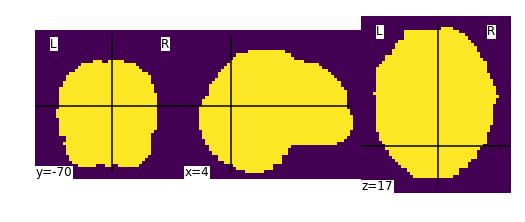

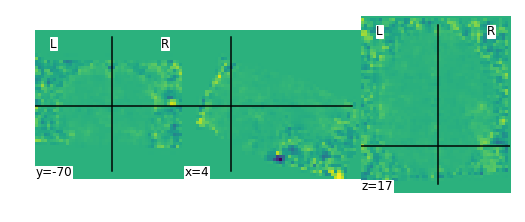

In [58]:
plotting.plot_img(mask_rs, cut_coords = (4, -70, 17) )
plotting.plot_img(dat_list[0], cut_coords = (4, -70, 17))

In [59]:
outdir = base_dir/'derivatives/meld/'
if not outdir.exists():
    outdir.mkdir()
run_n = 0

subjects = None
stimuli = None
if subjects is None:
    subjects = meta.subject.unique()
else:
    subjects = set(subjects.split(' '))
if stimuli is None:
    stimuli = meta.stimuli.unique()
else:
    stimuli = set(stimuli.split(' '))


In [63]:
keep_ind = (~meta['subject'].isin(bad_list)) & (meta['subject'].isin(subjects)) & (meta['stimuli'].isin(stimuli))
meta = meta.loc[keep_ind,:].reset_index(drop = True)
dep_data = dat_ar[keep_ind,:]
# filter bad values in dep_data
dep_data[dep_data > 100] = 100.
dep_data[dep_data < -100] = -100.
if len(dep_data) == 0:
    raise Exception("No trials selected based on criteria." \
                    " subjects = {subjects}, simuli = {stimuli}".format(subjects= ' '.join(subjects),
                                                                        stimuli= ' '.join(stimuli)))

In [64]:
meta['vocal'] = 0
meta.loc[meta.trial_type == 'nonvocal', 'vocal'] = -1
ind_data = meta.loc[:, ['subject','stimuli','vocal']]
ind_data.columns = ['subj', 'item', 'vocal']
ind_data['val'] = 0
ind_data = ind_data.to_records(index = False)

In [65]:
ind_data.shape, dep_data.shape, connectivity.shape, mask.shape, mask.sum()

((8400,), (8400, 139258), (139258, 139258), (139258,), 41850)

In [66]:
n_jobs = 32
me_s = meld.meld.MELD('val ~ vocal', '(vocal|subj) + (1|item)', 'subj',
                dep_data, ind_data, factors={'subj': None, 'item': None},
                use_ranks=False,
                feat_nboot=500, feat_thresh=0.05,
                dep_mask = mask,
                do_tfce=True,
                connectivity=connectivity, #shape=img_dat.shape,
                dt=.01, E=2/3., H=2.0,
                n_jobs=n_jobs, verbose=10,
                memmap=False
               )

Initializing...Done (18 sec)
Processing actual data...Done (7.8e+02 sec)


In [67]:
me_s._n_jobs = 10
me_s.run_perms(100)

Running 100 permutations...


[Parallel(n_jobs=10)]: Done   3 out of 100 | elapsed: 21.5min remaining: 695.1min
[Parallel(n_jobs=10)]: Done   1 out of 100 | elapsed: 21.5min remaining: 2130.0min
[Parallel(n_jobs=10)]: Done  14 out of 100 | elapsed: 42.1min remaining: 258.3min
[Parallel(n_jobs=10)]: Done  25 out of 100 | elapsed: 64.4min remaining: 193.3min
[Parallel(n_jobs=10)]: Done  36 out of 100 | elapsed: 85.3min remaining: 151.7min
[Parallel(n_jobs=10)]: Done  47 out of 100 | elapsed: 107.4min remaining: 121.1min
[Parallel(n_jobs=10)]: Done  58 out of 100 | elapsed: 128.7min remaining: 93.2min
[Parallel(n_jobs=10)]: Done  69 out of 100 | elapsed: 150.4min remaining: 67.6min
[Parallel(n_jobs=10)]: Done  80 out of 100 | elapsed: 172.7min remaining: 43.2min
[Parallel(n_jobs=10)]: Done  91 out of 100 | elapsed: 213.1min remaining: 21.1min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 215.0min finished


Done (1.3e+04 sec)


In [68]:
# Write out results
run_n = 1
pfmasks = np.array(me_s._pfmask).transpose((1, 0, 2))
t = me_s.get_t_features()
t = np.array(t['vocal']).reshape(dat_list[0].shape)
timg = image.new_img_like(dat_list[0], t)
timg.to_filename((outdir/('run_%03d_t.nii.gz'%run_n)).as_posix())
p = me_s.p_features
p = np.array(me_s.p_features['vocal']).reshape(dat_list[0].shape)
p_img = image.new_img_like(dat_list[0], t*(p<0.05))
p_img.to_filename((outdir/('run_%03d_p.nii.gz'%run_n)).as_posix())
t_thresh_img = image.new_img_like(dat_list[0], t*(p<0.05))
t_thresh_img.to_filename((outdir/('run_%03d_t_thresh.nii.gz'%run_n)).as_posix())

np.save((outdir/('run_%03d_tb.npy'%run_n)).as_posix(), np.concatenate(me_s._tb))

'../data/voice/derivatives/meld'

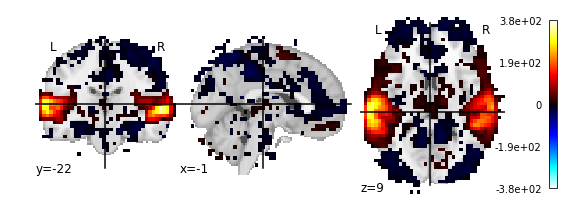

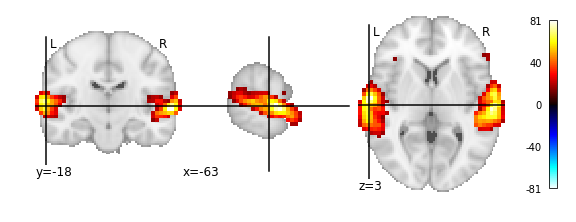

In [69]:
plotting.plot_stat_map(timg)
plotting.plot_stat_map(pimg)

In [36]:
re_group = 'subj'
_groups = np.unique(ind_data[re_group])
cep1

In [47]:
_A = {}
_M = {}
_O = {}
_D = {}
O = []
row_mask = None
_feat_shape = None
_dep_mask = mask
_do_tfce = True
_connectivity = connectivity

for g in _groups:
    # get that subj inds
    if isinstance(ind_data, dict):
        # the index is just the group into that dict
        ind_ind = g
    else:
        # select the rows based on the group
        ind_ind = ind_data[re_group] == g

    # process the row mask
    if row_mask is None:
        # no mask, so all good
        row_ind = np.ones(len(ind_data[ind_ind]), dtype=np.bool)
    elif isinstance(row_mask, dict):
        # pull the row_mask from the dict
        row_ind = row_mask[g]
    else:
        # index into it with ind_ind
        row_ind = row_mask[ind_ind]
    _O[g] = ind_data[ind_ind][row_ind]
    O.append(_O[g])
    if isinstance(dep_data, dict):
        # the index is just the group into that dict
        dep_ind = g
    else:
        # select the rows based on the group
        dep_ind = ind_ind
    # save feature shape if necessary
    if _feat_shape is None:
        _feat_shape = dep_data[dep_ind].shape[1:]

    # handle the mask
    if _dep_mask is None:
        _dep_mask = np.ones(self._feat_shape,
                                 dtype=np.bool)

    # create the connectivity (will mask later)
    if _do_tfce and _connectivity is None and \
       (len(_dep_mask.flatten()) > _dep_mask.sum()):
        # create the connectivity
        _connectivity = cluster.sparse_dim_connectivity([cluster.simple_neighbors_1d(n)
                                                              for n in _feat_shape])

    # Save D index into data (apply row and feature masks
    # This will also reshape it
    _D[g] = dep_data[dep_ind][row_ind][:, _dep_mask].copy()
    print(np.abs(_D[g]).sum())

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [56]:
np.abs(dep_data[dep_ind][row_ind])[:,_dep_mask]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [43]:
    # TODO: Make sure that there is still data in _D

    # reshape it
    #self._D[g] = self._D[g].reshape((self._D[g].shape[0], -1))
    if use_ranks:
        if verbose > 0:
            sys.stdout.write('Ranking %s...' % (str(g)))
            sys.stdout.flush()

        for i in range(self._D[g].shape[1]):
            # rank it
            self._D[g][:, i] = rankdata(self._D[g][:, i])

            # normalize it
            self._D[g][:, i] = ((self._D[g][:, i] - 1) /
                                (len(self._D[g][:, i]) - 1))

In [52]:
for g in self._groups:
            # get that subj inds
            if isinstance(ind_data, dict):
                # the index is just the group into that dict
                ind_ind = g
            else:
                # select the rows based on the group
                ind_ind = ind_data[re_group] == g

            # process the row mask
            if row_mask is None:
                # no mask, so all good
                row_ind = np.ones(len(ind_data[ind_ind]), dtype=np.bool)
            elif isinstance(row_mask, dict):
                # pull the row_mask from the dict
                row_ind = row_mask[g]
            else:
                # index into it with ind_ind
                row_ind = row_mask[ind_ind]

            # extract that group's A,M,O
            # first save the observations (rows of A)
            self._O[g] = ind_data[ind_ind][row_ind]
            if use_ranks:
                # loop over non-factors and rank them
                for n in self._O[g].dtype.names:
                    if (n in factors) or isinstance(self._O[g][n][0], str):
                        continue
                    self._O[g][n] = rankdata(self._O[g][n])
            O.append(self._O[g])

            # eventually allow for dict of data files for dep_data
            if isinstance(dep_data, dict):
                # the index is just the group into that dict
                dep_ind = g
            else:
                # select the rows based on the group
                dep_ind = ind_ind

            # save feature shape if necessary
            if self._feat_shape is None:
                self._feat_shape = dep_data[dep_ind].shape[1:]

            # handle the mask
            if self._dep_mask is None:
                self._dep_mask = np.ones(self._feat_shape,
                                         dtype=np.bool)

            # create the connectivity (will mask later)
            if self._do_tfce and self._connectivity is None and \
               (len(self._dep_mask.flatten()) > self._dep_mask.sum()):
                # create the connectivity
                self._connectivity = cluster.sparse_dim_connectivity([cluster.simple_neighbors_1d(n)
                                                                      for n in self._feat_shape])

            # Save D index into data (apply row and feature masks
            # This will also reshape it
            self._D[g] = dep_data[dep_ind][row_ind][:, self._dep_mask].copy()

            # TODO: Make sure that there is still data in _D

            # reshape it
            #self._D[g] = self._D[g].reshape((self._D[g].shape[0], -1))
            if use_ranks:
                if verbose > 0:
                    sys.stdout.write('Ranking %s...' % (str(g)))
                    sys.stdout.flush()

                for i in range(self._D[g].shape[1]):
                    # rank it
                    self._D[g][:, i] = rankdata(self._D[g][:, i])

                    # normalize it
                    self._D[g][:, i] = ((self._D[g][:, i] - 1) /
                                        (len(self._D[g][:, i]) - 1))

            # save M from D so we can have a normalized version
            self._M[g] = self._D[g].copy()

            # remove any NaN's in dep_data
            self._D[g][np.isnan(self._D[g])] = 0.0

            # normalize M
            if use_norm:
                self._M[g] -= self._M[g].mean(0)
                self._M[g] /= np.sqrt((self._M[g]**2).sum(0))

            # determine A from the model.matrix
            rdf = DataFrame({k: (FactorVector(self._O[g][k])
                                 if k in factors else self._O[g][k])
                             for k in self._O[g].dtype.names})

            # model spec as data frame
            ms = r['data.frame'](r_model_matrix(Formula(fe_formula), data=rdf))

            cols = list(r['names'](ms))
            if svd_terms is None:
                self._svd_terms = [c for c in cols
                                   if 'Intercept' not in c]
            else:
                self._svd_terms = svd_terms

            # self._A[g] = np.vstack([ms[c] #np.array(ms.rx(c))
            self._A[g] = np.concatenate([np.array(ms.rx(c))
                                         for c in self._svd_terms]).T

            if use_ranks:
                for i in range(self._A[g].shape[1]):
                    # rank it
                    self._A[g][:, i] = rankdata(self._A[g][:, i])

                    # normalize it
                    self._A[g][:, i] = ((self._A[g][:, i] - 1) /
                                        (len(self._A[g][:, i]) - 1))

            # normalize A
            if True:  # use_norm:
                self._A[g] -= self._A[g].mean(0)
                if not ((self._A[g].max() == self._A[g].min()) & (self._A[g].min() == 0)):
                    self._A[g] /= np.sqrt((self._A[g]**2).sum(0))

            # memmap if desired
            if self._memmap:
                self._M[g] = _memmap_array(self._M[g], memmap_dir,
                                           unique_id=str(g))
                self._D[g] = _memmap_array(self._D[g], memmap_dir,
                                           unique_id=str(g))

NameError: name '_global_meld' is not defined

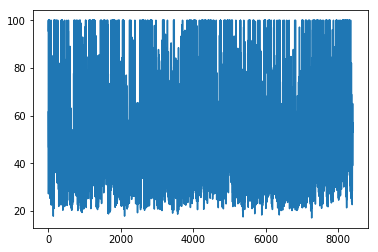

In [25]:
plt.plot(dep_data.max(1))